In [3]:
# README.

from IPython.display import display, Markdown

with open('README.md') as f:
    display(Markdown(f.read()))

# Talent Search

This project explores the implications of the talent search strategy used by a hypothetical
tech giant's engineering teams. The strategy can be summarized as follows:

> Only hire people who are better than 50% of those already in the role.

Effectively, this strategy creates a simple rule that must be followed in order to execute
the strategy successfully (referred to as "the rule" below):

> A new hire's talent rating must be in the 50th percentile (or higher) of existing
> employees' talent ratings.

This Jupyter notebook implements a simulation of this hiring strategy that obeys the rule, until
it is no longer possible to hire anyone else while still following the rule. The simulation
makes the following assumptions:

* In this hypothetical scenario, talent is the sole criterion that determines if a candidate is
  suitable for a role. Talent is modeled as a simple scalar value, and a candidate with a
  talent score above some threshold (as determined by the rule) is suitable to be hired.
* Talent is normally distributed among the population with a mean of 0.5 and a standard deviation
  of 0.15. (This roughly puts the range of talent scores between 0 and 1.)
* At time t = 0, when this hiring strategy is implemented, there is some existing set of employees
  already in the role. (Otherwise, it is impossible to know if new candidates are more or less
  talented than "those already in the role," which is necessary in order to follow the rule.)
  Further, we assume that at time t = 0, talent is normally distributed among the existing employees
  with the same mean and standard deviation as the population of candidates (as described above).
* There are an infinite number of roles to fill, i.e., the only limit to the hiring process is
  when no more candidates can be hired while still following the rule.
* When filling a role, candidates are hired randomly from the set of suitable candidates (as
  described above). In other words, any candidate with a talent score above the threshold dictated
  by the rule is equally likely to be hired.

In [4]:
# Imports.

import bisect
import math
import random

import matplotlib.pyplot as plt
import numpy as np

In [5]:
# Define constants.

# Talent is modeled as a normal distribution with a mean of 0.5 and a standard deviation of 0.15.
MEAN_TALENT_SCORE = 0.5
TALENT_SCORE_STD_DEV = 0.15

# The percentile threshold for hiring a new employee; 0.5 corresponds to the 50th percentile.
TALENT_THRESHOLD_PERCENTILE = 0.5

# The initial number of employees at time t = 0.
INITIAL_EMPLOYEE_POP_SIZE = 1000

In [6]:
# Given a sorted population of values and a percentile threshold between 0 and 1, inclusive,
# return the value at the given percentile using the nearest-rank method.
# See: https://en.wikipedia.org/wiki/Percentile#The_nearest-rank_method.
def percentile(population: list[float], threshold: float) -> float:
    n = math.floor(threshold * len(population))
    return population[n]

In [7]:
# Compute a weighted mean given a previous mean and a new value to incorporate into the mean.
# See: https://en.wikipedia.org/wiki/Weighted_arithmetic_mean#Mathematical_definition.
def weighted_mean(n: int, prev_mean: float, value: float) -> float:
    return ((n * prev_mean) + value) / (n + 1)

In [8]:
# Simulate hiring employees by following the talent threshold rule until it is no longer possible to maintain the rule.
# Returns the number of iterations completed, the minimum talent scores required for each iteration, and the talent
# scores for the population of candidates and for the employees after the final iteration.
def simulate(candidate_pop_size: int,
             initial_employee_pop_size: int = INITIAL_EMPLOYEE_POP_SIZE,
             initial_employee_talent_mean: float = MEAN_TALENT_SCORE,
             talent_threshold_percentile: float = TALENT_THRESHOLD_PERCENTILE
             ) -> tuple[int, list[float], list[float], list[float]]:
    # Validate arguments.
    assert candidate_pop_size > 0
    assert initial_employee_pop_size > 0
    assert 0 < initial_employee_talent_mean < (MEAN_TALENT_SCORE + (3 * TALENT_SCORE_STD_DEV))
    assert 0 < talent_threshold_percentile < 1

    # Create a population of candidates with a normal distribution of talent scores.
    candidates = sorted(np.random.normal(MEAN_TALENT_SCORE, TALENT_SCORE_STD_DEV, candidate_pop_size))
    # plot_scores_histogram(population, title='Candidate Talent Scores (before)')

    # Create the list of current employees.
    employees = sorted(np.random.normal(initial_employee_talent_mean, TALENT_SCORE_STD_DEV, initial_employee_pop_size))
    # plot_scores_histogram(employees, title='Employee Talent Scores (before)', bins=20)

    i = 1
    employee_talent_mean = initial_employee_talent_mean
    min_talent_scores = []
    while True:
        # Find the minimum talent score needed to maintain the rule.
        min_talent_score = percentile(employees, talent_threshold_percentile)
        min_talent_scores.append(min_talent_score)

        # If possible, find and remove a random candidate from the population with an acceptable talent score.
        min_index = bisect.bisect(candidates, min_talent_score)
        if min_index >= len(candidates):
            print(f'Failed to find a candidate with a talent score above {min_talent_score:0.5f} '
                  f'after {i:,} iterations')
            break
        selected_index = random.randrange(min_index, len(candidates))
        selected_talent_score = candidates.pop(selected_index)

        # Add the selected candidate to the list of employees, and update the current mean employee talent score.
        employee_talent_mean = weighted_mean(len(employees), employee_talent_mean, selected_talent_score)
        bisect.insort(employees, selected_talent_score)

        # if i % 1000 == 0:
        #     print(f'[{i:,}] Minimum score: {min_talent_score:0.5f}, new mean: {employee_talent_mean:0.5f} '
        #           f'(population: {len(population):,}, employees: {len(employees):,})')
        i += 1

    return i, min_talent_scores, candidates, employees

In [9]:
# Run multiple simulations, returning the average number of iterations from all simulations.
def simulate_many(n: int = 10, **kwargs) -> int:
    counts = []
    for _ in range(n):
        count, _, _, _ = simulate(**kwargs)
        counts.append(count)
    return int(sum(counts) / len(counts))

In [10]:
# Return the coefficients a and b for the logarithmic curve of best fit for the given values.
# The coefficients a and b correspond to the equation: y = a + b * ln(x).
def log_regression(values: list[float]) -> tuple[float, float]:
    x = np.arange(1, len(values) + 1)
    y = np.array(values)
    fit = np.polyfit(np.log(x), y, 1)
    b, a = fit
    print(f'\nLogarithmic regression fit function: y = {a:0.5f} + {b:0.5f} * ln(x)')
    return a, b

In [11]:
# Given a list of scores, show the scores as a scatter plot vs. time, optionally with a line of best fit.
def plot_scores_vs_time(scores: list[float], show_fit: bool = False) -> None:
    _, ax = plt.subplots()
    x = np.arange(1, len(scores) + 1)
    ax.scatter(x, scores)

    if show_fit:
        a, b = log_regression(scores)
        ax.plot(x, a + b * np.log(x), c='r')

    ax.set_title('Minimum Talent Scores vs. Time')
    ax.set_xlabel('Iteration')
    ax.set_ylabel('Min. Talent Score')
    plt.show()

In [12]:
# Given a list of scores, show the scores as a histogram.
def plot_scores_histogram(scores: list[float], title: str, bins: int = 100) -> None:
    _, ax = plt.subplots()
    ax.hist(scores, bins=min(bins, len(scores)))
    ax.set_title(title)
    ax.set_xlabel('Talent Score')
    ax.set_ylabel('Count')
    plt.show()

Failed to find a candidate with a talent score above 0.82401 after 29,903 iterations


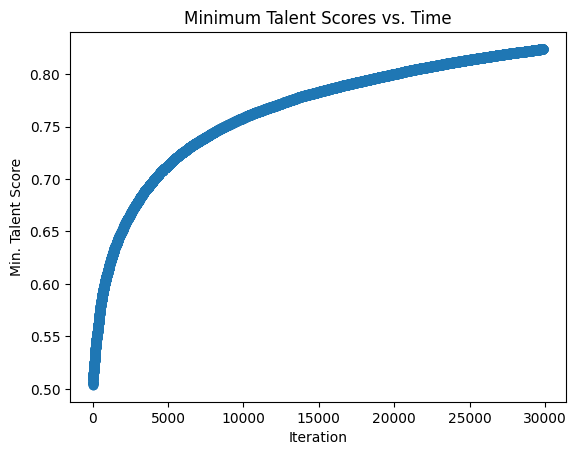

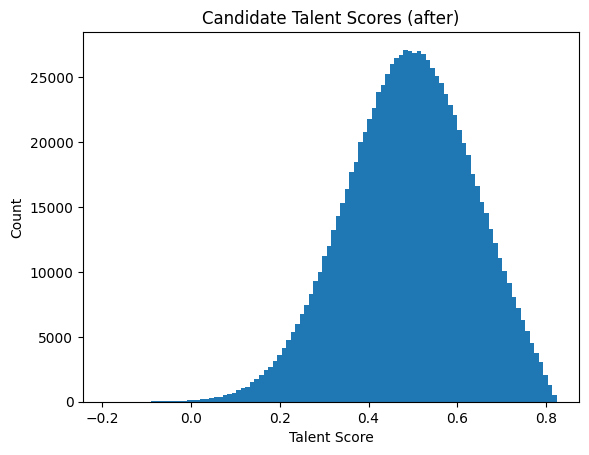

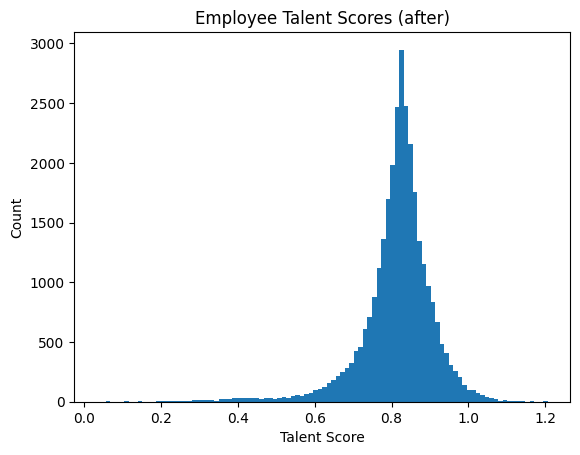

In [13]:
# Run the simulation and plot the results.
def run_simulation() -> None:
    iterations, min_talent_scores, candidate_talent_scores, employee_talent_scores = simulate(candidate_pop_size=1_000_000)
    # log_regression(min_talent_scores)
    plot_scores_vs_time(min_talent_scores)
    plot_scores_histogram(candidate_talent_scores, title='Candidate Talent Scores (after)')
    plot_scores_histogram(employee_talent_scores, title='Employee Talent Scores (after)')

run_simulation()

In [14]:
# Run 100 simulations and print the mean number of iterations required to achieve maximum possible talent.
def run_simulations() -> None:
    mean_iterations = simulate_many(n=100, candidate_pop_size=1_000_000)
    print(f'\nCompleted an average of {mean_iterations:,} iterations before maximum possible talent was achieved')

# run_simulations()